#MNIST
- 손으로 직접 쓴 흑백의 숫자
- data : 숫자이미지(28X28), 레이블(0~9)
- train data : 60,000개, test data : 10,000개

### dataset 다운

In [1]:
from tensorflow.keras.datasets.mnist import load_data
(x_train, y_train),(x_test,y_test) = load_data(path='mnist.npz')

11490434/11490434 [==============================] - 0s 0us/step


### data 형태 확인

In [2]:
# 학습데이터
print(x_train.shape, y_train.shape)
print(y_train)
# 테스트데이터
print(x_test.shape, y_test.shape)
print(y_test)

(60000, 28, 28) (60000,)
[5 0 4 ... 5 6 8]
(10000, 28, 28) (10000,)
[7 2 1 ... 4 5 6]


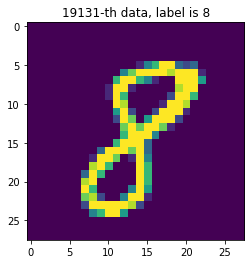

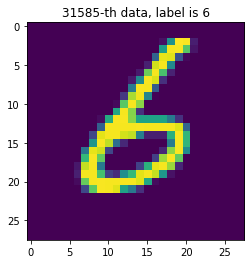

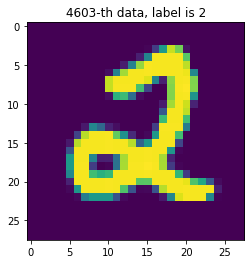

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 0~59999의 범위에서 세 개의 정수 뽑기
sample_size = 3
random_idx = np.random.randint(60000, size=sample_size)

for idx in random_idx:
  img = x_train[idx, :]
  label = y_train[idx]
  plt.figure()
  plt.imshow(img)
  plt.title('%d-th data, label is %d' %(idx, label))

### validation data 만들기
[ sklearn 패키지 train_test_split() 함수]
- 데이터셋을 각 세트(학습, 검증,테스트)로 분리할 때 사용합니다
- 첫번째 두번째 인자에는 나눠줄 대상을 넣어줍니다
- test_size는 테스트셋의 비율
- random_state는 재생산성을 위해 사용합니다
  - 간혹 모델의 결과값을 출력했을 때, 매번 다른 값을 얻게 되는데, 이 경우에 학습데이터가 이전과 동일한지 확인해봐야합니다.
  - 데이터 구성과정에서 train_test_split()과 같은 함수를 사용하면 학습데이터가 이전과 동일한지 꼭 확인해야합니다.

In [4]:
from sklearn.model_selection import train_test_split

# train : val = 7 : 3
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=777)
print(f'train data : {x_train.shape}, label : {y_train.shape}')
print(f'validation data : {x_val.shape}, label : {y_val.shape}')

train data : (42000, 28, 28), label : (42000,)
validation data : (18000, 28, 28), label : (18000,)


### 데이터 전처리
- Dense층에 데이터를 입력하기 위해 2차원 배열로 이루어진 숫자 이미지 데이터를 1차원 배열로 변환해야 합니다.
- 28X28 형태의 데이터를 784차원의 1차원 배열로 변환
- 신경망은 입력 데이터의 스케일에 매우 민감하므로 적절한 전처리 과정이 필수입니다
  - gradient vanishing과 exploding으로 인해 학습이 진행 되지 않을 수 있기 때문입니다

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28*28).astype('float32')
x_val = x_val.reshape(x_val.shape[0], 28*28).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28*28).astype('float32')

# 숫자 이미지 데이터는 픽셀 값이 0~255 범위에 있기 떄문에 255로 나누어 0~1범위로 표준화(normalization)
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

print(x_train.shape)

(42000, 784)


###레이블 전처리
[ to_categorical ] : one-hot encoding을 해주는 함수 
- 원핫인코딩 : 10진 정수 형식을 특수 2진 바이너리 형식으로 변환해주는 인코딩 방식

In [6]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
print(y_train)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 모델 구성

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
#입력데이터의 형태를 꼭 명시해야함
#784차원의 데이터를 입력으로 받고,64개의 출력을 가지는 첫번쨰 Dense층
model.add(Dense(64, activation='relu', input_shape=(784,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))  #범주형 데이터 : 마지막레이어 활성화함수 softmax

- softmax와 sigmoid 값 비교

In [10]:
def softmax(arr):
  m = np.max(arr)
  arr = arr - m
  arr = np.exp(arr)
  return arr/np.sum(arr)

def sigmoid(x):
  return 1/(1+np.exp(-x))

case1 = np.array([3.1, 3.0, 2.9])
case2 = np.array([2.0, 1.0, 0.7])

np.set_printoptions(precision=3)
print(f'sigmoid {sigmoid(case1)}, softmax {softmax(case1)}')
print(f'sigmoid {sigmoid(case2)}, softmax {softmax(case2)}')
print('softmax를 통해 얻은 값들의 비교가 훨씬 수월함')

sigmoid [0.957 0.953 0.948], softmax [0.367 0.332 0.301]
sigmoid [0.881 0.731 0.668], softmax [0.61  0.224 0.166]
softmax를 통해 얻은 값들의 비교가 훨씬 수월함


### 학습과정 설정

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

### 모델 학습

In [12]:
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/30
329/329 [==============================] - 4s 5ms/step - loss: 0.4914 - acc: 0.8612 - val_loss: 0.2527 - val_acc: 0.9283
Epoch 2/30
329/329 [==============================] - 1s 4ms/step - loss: 0.2109 - acc: 0.9397 - val_loss: 0.1896 - val_acc: 0.9447
Epoch 3/30
329/329 [==============================] - 1s 4ms/step - loss: 0.1582 - acc: 0.9537 - val_loss: 0.1636 - val_acc: 0.9517
Epoch 4/30
329/329 [==============================] - 1s 4ms/step - loss: 0.1304 - acc: 0.9616 - val_loss: 0.1478 - val_acc: 0.9557
Epoch 5/30
329/329 [==============================] - 1s 4ms/step - loss: 0.1094 - acc: 0.9685 - val_loss: 0.1353 - val_acc: 0.9593
Epoch 6/30
329/329 [==============================] - 1s 4ms/step - loss: 0.0933 - acc: 0.9725 - val_loss: 0.1201 - val_acc: 0.9646
Epoch 7/30
329/329 [==============================] - 2s 5ms/step - loss: 0.0797 - acc: 0.9761 - val_loss: 0.1181 - val_acc: 0.9653
Epoch 8/30
329/329 [==============================] - 1s 4ms/step - loss: 0.

In [13]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

### 학습결과

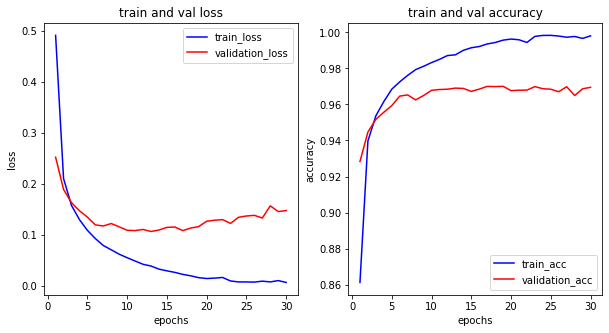

In [17]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss)+1)
fig = plt.figure(figsize=(10,5))

#학습 및 검증 손실 그리기
ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, 'b', label='train_loss')
ax1.plot(epochs, val_loss, 'r', label='validation_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

#학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, 'b', label='train_acc')
ax2.plot(epochs, val_acc, 'r', label='validation_acc')
ax2.set_title('train and val accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax2.legend()

plt.show()

### 모델 평가

In [18]:
model.evaluate(x_test, y_test)
# 출력값 첫번쨰는 손실값, 두번쨰는 정확도

313/313 [==============================] - 2s 5ms/step - loss: 0.1538 - acc: 0.9706


[0.15376313030719757, 0.9706000089645386]

- 학습된 모델로 예측해보기

In [19]:
results = model.predict(x_test)
print(results.shape)
np.set_printoptions(precision=7)
print(f'각 클래스에 속할 확률: \n{results[0]}')

313/313 [==============================] - 1s 2ms/step
(10000, 10)
각 클래스에 속할 확률: 
[3.9712282e-09 1.8154238e-12 5.4249383e-10 3.6026941e-06 3.2052658e-15
 1.1744454e-10 8.4208925e-20 9.9999630e-01 1.7401338e-09 1.5013859e-07]


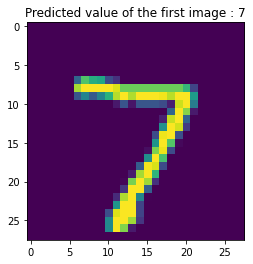

In [21]:
arg_results = np.argmax(results, axis=-1)
plt.imshow(x_test[0].reshape(28,28))
plt.title('Predicted value of the first image : '+ str(arg_results[0]))
plt.show()

- 혼동행렬(confusion matrix)와 분류보고서

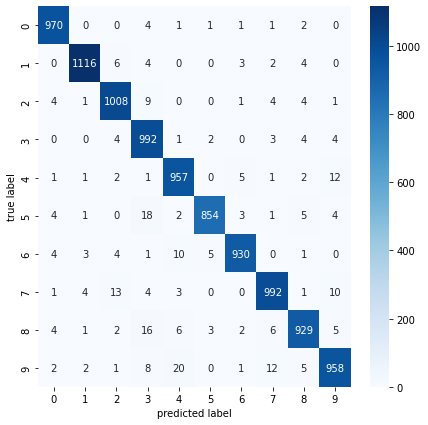


               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.94      0.98      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.99      0.96      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.97      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.figure(figsize=(7,7))
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(results, axis=-1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

print('\n', classification_report(np.argmax(y_test, axis=-1), np.argmax(results, axis=-1)))